In [1]:
import gym 
import numpy as np
import pandas as pd

env = gym.make("MountainCar-v0")

In [2]:
# Print out state space type.
print("States:", env.observation_space)
# Print out action space type.
print("Actions: ", env.action_space, end="\n\n")

# Print out the observation space boundaries.
print("State Low: ", env.observation_space.low)
print("state High: ", env.observation_space.high, end="\n\n")

# Generate some action samples:
print("Action space samples: ", [env.action_space.sample() for _ in range(5)])
# Generate some state samples:
print("State space samples: ", [list(env.observation_space.sample()) for _ in range(3)])

States: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Actions:  Discrete(3)

State Low:  [-1.2  -0.07]
state High:  [0.6  0.07]

Action space samples:  [1, 2, 0, 2, 0]
State space samples:  [[0.015224262, 0.019219099], [0.5720324, -0.054928284], [-0.47429138, -0.010854964]]


In [3]:
# Random agent interacting with the environment.
env.reset()
score = 0
while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    score += reward
    if done:
        break
env.close()
print("Score = ", score)

Score =  -200.0


In [4]:
import matplotlib.collections as mc
import matplotlib.pyplot as plt
class Preprocess:
    def __init__(self, low=[-1.0, -5.0], high=[1.0, 5.0], bins=(10, 10)):
        self.low = low
        self.high = high
        self.bins = bins
        self.grid = self.create_uniform_grid()
        self.samples_stored = False
        
    def create_uniform_grid(self):
        grid = []
        for i, b in enumerate(self.bins):
            grid.append(np.linspace(start=self.low[i], stop=self.high[i], num=b, endpoint=False)[1:])
        return grid
    
    def discretize(self, state):
        return list(np.digitize(sample, grid) for sample, grid in zip(state, self.grid))
    
    def store_samples(self, samples, info=False):
        self.samples_stored = True
        self.samples = samples
        self.discretized_samples = np.array([temp.discretize(sample) for sample in samples])
        if info:
            print("\nSamples:", repr(self.samples), sep="\n")
            print("\nDiscretized samples:", repr(self.discretized_samples), sep="\n")
            
    def visualize_samples(self):
        if self.samples_stored == False:
            print("Error: Store some samples first")
            return
        
        low = self.low
        high = self.high
        grid = self.grid
        samples = self.samples
        discretized_samples = self.discretized_samples
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
        ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
        ax.grid(True)
        if low is not None and high is not None:
            ax.set_xlim(low[0], high[0])
            ax.set_ylim(low[1], high[1])
        else:
            low = [splits[0] for splits in grid]
            high = [splits[-1] for splits in grid]
        grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
        grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
        locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples
        ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
        ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
        ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
        ax.legend(['original', 'discretized'])


Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


/opt/homebrew/Caskroom/miniforge/base/envs/py39-tf-m1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


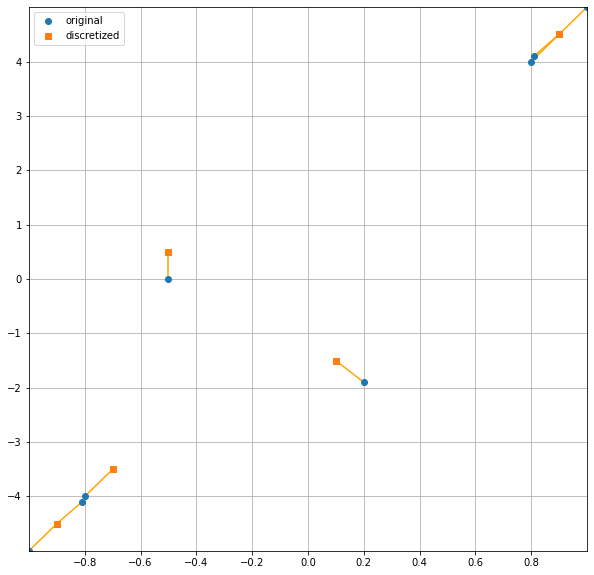

In [5]:
# Testing the preprocess class.
temp = Preprocess()
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
temp.store_samples(samples, True)
temp.visualize_samples()

In [6]:
import sys
import time

class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, bins=(50, 50), alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        
        # Environment info
        self.bins = bins
        self.env = env
        self.state_grid = self.create_uniform_grid()
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        self.samples_stored = False
        self.training_done = False
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)
    
    def create_uniform_grid(self):
        grid = []
        for i, b in enumerate(self.bins):
            grid.append(np.linspace(start=self.env.observation_space.low[i], 
                                    stop=self.env.observation_space.high[i], num=b, endpoint=False)[1:])
        return grid
    
    def discretize(self, state):
        return list(np.digitize(sample, grid) for sample, grid in zip(state, self.state_grid))
    
    def store_samples(self, samples, info=False):
        self.samples_stored = True
        self.samples = samples
        self.discretized_samples = np.array([temp.discretize(sample) for sample in samples])
        if info:
            print("\nSamples:", repr(self.samples), sep="\n")
            print("\nDiscretized samples:", repr(self.discretized_samples), sep="\n")
            
    def visualize_samples(self):
        if self.samples_stored == False:
            print("Error: Store some samples first")
            return
        
        low = self.low
        high = self.high
        grid = self.grid
        samples = self.samples
        discretized_samples = self.discretized_samples
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
        ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
        ax.grid(True)
        if low is not None and high is not None:
            ax.set_xlim(low[0], high[0])
            ax.set_ylim(low[1], high[1])
        else:
            low = [splits[0] for splits in grid]
            high = [splits[-1] for splits in grid]
        grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
        grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
        locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples
        ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
        ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
        ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
        ax.legend(['original', 'discretized'])

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        return tuple(self.discretize(state))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
        
    def plot_scores(self, rolling_window=100):
        """Plot scores and optional rolling mean using specified window."""
        if self.training_done == False:
            print("Error: Training not done")
        scores = self.scores
        plt.plot(scores); plt.title("Scores");
        rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
        plt.plot(rolling_mean);
    
    def plot_q_table(self):
        """Visualize max Q-value for each state and corresponding action."""
        q_table = self.q_table
        q_image = np.max(q_table, axis=2)       # max Q-value for each state
        q_actions = np.argmax(q_table, axis=2)  # best action for each state

        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.imshow(q_image, cmap='jet');
        cbar = fig.colorbar(cax)
        for x in range(q_image.shape[0]):
            for y in range(q_image.shape[1]):
                ax.text(x, y, q_actions[x, y], color='white',
                        horizontalalignment='center', verticalalignment='center')
        ax.grid(False)
        ax.set_title("Q-table, size: {}".format(q_table.shape))
        ax.set_xlabel('position')
        ax.set_ylabel('velocity')

    def act(self, state, reward=None, done=None, mode='train', time_delay=0.01):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
            time.sleep(time_delay)
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action
    
    def run(self, num_episodes=20000, mode="train", time_delay=0.01):
        """Run agent in given reinforcement learning environment and return scores."""
        scores = []
        max_avg_score = -np.inf
        for i_episode in range(1, num_episodes+1):
            # Initialize episode
            state = self.env.reset()
            action = self.reset_episode(state)
            total_reward = 0
            done = False

            # Roll out steps until done
            while not done:
                if mode=='test':
                    env.render()
                state, reward, done, info = self.env.step(action)
                total_reward += reward
                action = self.act(state, reward, done, mode, time_delay)
            
            # Save final score
            scores.append(total_reward)

            # Print episode stats
            if mode == 'train':
                self.training_done = True
                if len(scores) > 100:
                    avg_score = np.mean(scores[-100:])
                    if avg_score > max_avg_score:
                        max_avg_score = avg_score
                if i_episode % 100 == 0:
                    print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                    sys.stdout.flush()
        
        # Close rendering
        env.close()
        if mode == "test":
            print("Score: ", np.mean(scores))
        else:
            self.scores = scores

In [7]:
# Creating the agent
agent = QLearningAgent(env, bins = (20, 20))

Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (20, 20)
Action space size: 3
Q table size: (20, 20, 3)


In [8]:
# Training the agent
agent.run(num_episodes = 100000, mode="train")

Episode 100000/100000 | Max Average Score: -109.27

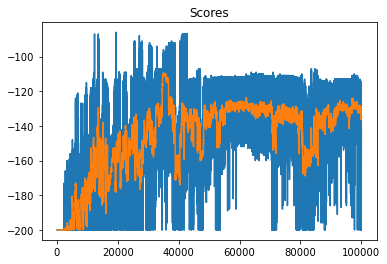

In [9]:
# Visualize the scores
agent.plot_scores()

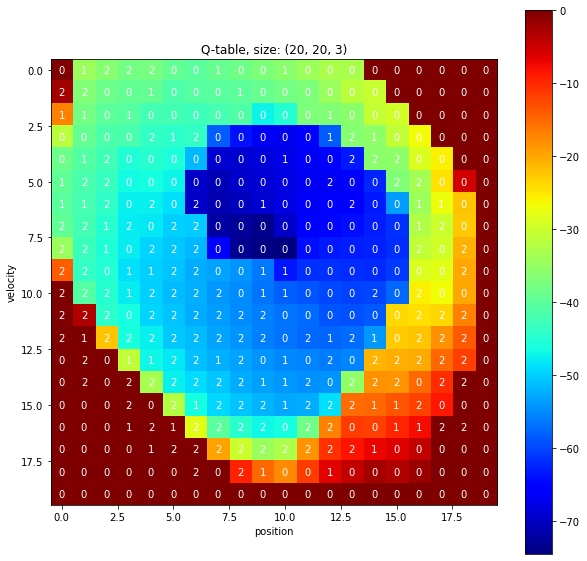

In [10]:
# Visualize the Q-Table
agent.plot_q_table()

In [15]:
# Testing the agent
agent.run(num_episodes=1, mode="test", time_delay = 0.01)

Score:  -118.0
